In [1]:
import nibabel as nib
import numpy as np
from sklearn.linear_model import Lasso,LassoCV,LinearRegression,Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom

from orelmisc import n_max,n_test_max,testpre,trainpre,saveCSV,y_org,shape_3d_org
from preprocess import flatten,flatten_each_sample,loadData,flatten_each_sample,precompute_and_save

In [2]:
prep = lambda i: int(i)
x_org = None
x_t_org = None
xa_org = None
d_org = None
y = y_org
y_t_pred = None
y_t_pp = None
prefix=None
alpha = 0
result = None
xa = []
x = None
x_t = None

In [3]:
name = "PureLassoStatDataHist_Demo"
fname = "mean_std_hist120_scale1.npy"

xa = np.load(fname)
x = xa[0:n_max,:]
x_t = xa[n_max:,:]

In [4]:
def myloop(a):
    return (a,a*a,a*a*a)

myloopU = np.frompyfunc(myloop,1,3,dtype=np.float64)

def loadAndPreprocess():
    global d_org,x,x_t,xa,x_org,x_t_org,xa_org
    d_org = 6443008
    space = 120
    bins = np.linspace(250,2600,space)
    xa = np.zeros((n_max+n_test_max,5+space-1))
    
    """
    => This wassed to preprocess the data.
    The sum of the data to the powers 1,2 and 3 were taken. Mean and Var was calculated
    and a histogram of all voxel-values was created.
    i = 0
    while i < n_max+n_test_max:
      if i % 5 == 0:
        print "Doing i = %s ..." % i
      
      n_i,pre,t_str = (n_max,"set_train/","train") if i < n_max else (n_test_max,"set_test/","test")
      filename = "%s%s_%s.nii" % (pre,t_str,i%n_max+1)
      data = nib.load(filename).get_data()
      #data=xa_org[i]
      sum = 0.0
      sum2 = 0.0
      sum3 = 0.0
      avg = 0.0
      var = 0.0
      data = data.ravel()
      res = myloopU(data)
      sum = np.sum(res[0])
      sum2 = np.sum(res[1])
      sum3 = np.sum(res[2])
      avg = sum / float(d_org)
      var = sum2 - avg*avg
      xa[i,:5] = [sum,sum2,sum3,avg,var]
      xa[i,5:] = np.histogram(data,bins=bins)[0]
      i = i+1"""
    x = xa[0:n_max]
    x_t=xa[n_max:]

## SCHLUSSFOLGERUNG: brauche ein isschen mehr sachen als nur diese momente und summen.
# vielleicht ein grobes histogram?
# pures Lasso und SVD+Lasso waren am besten... mit RSS 155...

## SCLUSSFOLGERUNG 2:
# Pures Lasso mit alpha = 750 war gut. RSS 84 ..
# SVD auf das Histogram bringt keinen Mehrwert...
# Das Ergebnis wrde allein durch die Momente und Statistischen Werte erreicht!!
# [sum,sum2,sum2,avg,var]

# SCHLUSSFOLGERUNG 3:
# Pures Lasso auf den statistischen daten und dem histogram. Mit alpha = 870 wurde bis zu RSS 77 erreicht!
# wir sind damit unter der öffentlichen Schranke von 80 angelangt!

In [5]:
# print y
# loadAndPreprocess() # was used to

In [6]:
def makeLassoPrediction(al):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s" % alpha
  prefix = "%s_LassoPure_alpha%s_FULL"%(name,alpha)
  model = Lasso(alpha=alpha)
  x1 = x # use all data
  x_t1 = x_t # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % model.intercept_
  print "Coefficients: %s..." % model.coef_[:5]
  print "Abs-Val largest coefficients: %s..." % (sorted(enumerate(model.coef_),key=lambda x:abs(x[1]))[:5])
  plt.clf()
  bla = sorted(model.coef_)
  bla.reverse()
  plt.plot(bla,"ro",label="coefficients")
  plt.show()
  return prefix


In [7]:
def doStuff(al=15,comps=n_max-1):
  global prefix,result
  #loadAndPreprocess()
  
  prefix = makeLassoPrediction(al=al)
  #prefix = makeSVDLassoPrediction(al=al,comps=comps)
  #prefix = makeLassoCVPrediction(cv=3)
  #prefix = makeLinearRegression()
  #prefix = makeRidgePrediction(al=al)
  #prefix = makeGaussianProcess()
  
  y_t_pp = savePrediction()
  
  visualize(y,y_t_pp,prefix)
  
  print " ========= x ========== \n%s\n" % x
  print " ========= y_t_pp ========== \n%s\n" % y_t_pp
  
  # retuns a colleciton of stuff to return
  print "Variables available in 'result'"
  result = (x,y,x_t,y_t_pred,y_t_pp)

def visualize(y,y_t_pp,prefix):
  """ Step 5: make histogram plot of age """
  # (because no visualization for flat data matrix...)
  plt.hist(y,color="black",rwidth=0.7)
  #plt.hist(y_pred,color="darkgreen",rwidth=0.5)
  plt.hist(y_t_pp,color="darkblue",rwidth=0.5)
  plt.legend(["ages given for X",
    #"ages predicted for X",
    "ages predicted for X_t"])
  plt.savefig(prefix + "_histogram_ages.png")
  plt.show()
  plt.clf()
  plt.clf()
  plt.plot(np.sort(y),"bo")
  plt.savefig(prefix + "_sorted_ages.png")
  print("Saved age diagram in %s"%(prefix+"<...>.png"))
  plt.show()

def savePrediction():
    global y_t_pp
    y_t_pp = [prep(i) for i in y_t_pred]
    savedFilename = saveCSV(y_t_pp,prefix)
    print("Saved predictions into %s" % savedFilename)
    return y_t_pp

Prediction with alpha = 870
score r = 0.89938636842
Intercept: 398.287076302
Coefficients: [ -2.45856605e-07  -3.21041589e-11  -7.98242939e-14  -0.00000000e+00
   1.86655520e-10]...
Abs-Val largest coefficients: [(3, -0.0), (5, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)]...


/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


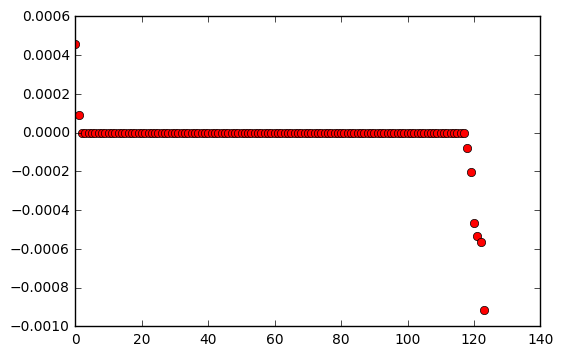

Saved predictions into PureLassoStatDataHist_Demo_LassoPure_alpha870_FULL.csv


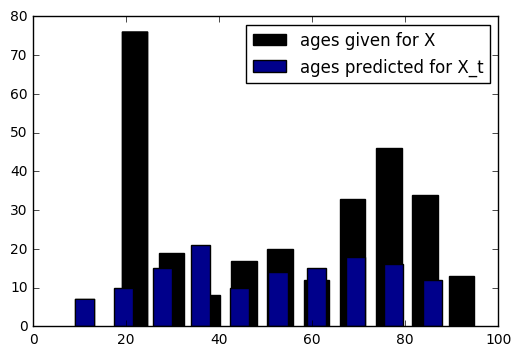

Saved age diagram in PureLassoStatDataHist_Demo_LassoPure_alpha870_FULL<...>.png


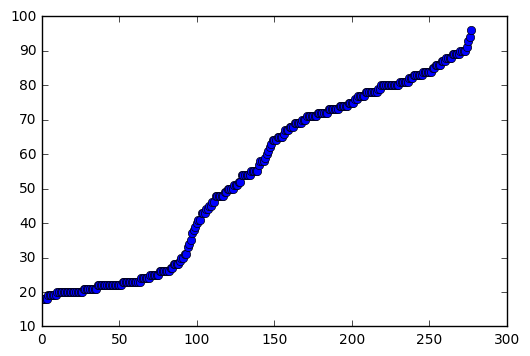

 ========= x ========== 
[[  1.50725930e+09   1.51216940e+12   1.64032931e+15 ...,   2.00000000e+00
    3.00000000e+00   1.00000000e+00]
 [  1.51397922e+09   1.54599576e+12   1.71971056e+15 ...,   3.00000000e+00
    0.00000000e+00   2.00000000e+00]
 [  1.52006085e+09   1.57387665e+12   1.76660383e+15 ...,   5.00000000e+00
    6.00000000e+00   1.00000000e+00]
 ..., 
 [  1.52169988e+09   1.54359292e+12   1.68726157e+15 ...,   7.00000000e+00
    5.00000000e+00   5.00000000e+00]
 [  1.52123657e+09   1.56384761e+12   1.75263246e+15 ...,   9.00000000e+00
    5.00000000e+00   8.00000000e+00]
 [  1.53099490e+09   1.57102397e+12   1.74253079e+15 ...,   1.20000000e+01
    9.00000000e+00   1.30000000e+01]]

 ========= y_t_pp ========== 
[60, 70, 50, 74, 70, 72, 52, 54, 62, 53, 29, 56, 61, 39, 31, 63, 26, 68, 89, 81, 85, 32, 70, 87, 65, 49, 72, 16, 27, 34, 67, 43, 10, 26, 24, 61, 80, 87, 62, 85, 38, 66, 81, 33, 60, 55, 43, 34, 26, 69, 23, 79, 18, 49, 28, 83, 71, 75, 17, 50, 60, 74, 44, 56, 14, 35,

In [8]:
doStuff(al=870)

In [10]:
x.shape

(278, 124)